# Exploring waveforms

In this example we will show how you can explore the waveforms extracted during spikesorting. During spike sorting, pre-processing operations are performed on the voltage data to create the average templates. Although those templates are useful for clustering, they may not be the best description of the neural activity. As such we extract average waveforms for each cluster using a different pre-processing method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import one.alf.io as alfio
from iblatlas.regions import BrainRegions
import ibldsp.waveforms
from ibldsp.utils import rms
from ibldsp.waveform_extraction import WaveformsLoader
from brainbox.io.one import SpikeSortingLoader, _channels_alf2bunch
from ibl_style.style import figure_style
figure_style()

regions = BrainRegions()

np1_data = Path('/Users/admin/Downloads/cajal/np1')

ss_path = np1_data.joinpath('spikesorting')
spikes = alfio.load_object(ss_path, 'spikes')
clusters = alfio.load_object(ss_path, 'clusters')
channels = alfio.load_object(ss_path, 'channels')
channels = _channels_alf2bunch(channels, brain_regions=regions)
clusters = SpikeSortingLoader.merge_clusters(spikes, clusters, channels)
waveforms = alfio.load_object(ss_path, 'waveforms', attribute=['templates'])

## Displaying average waveforms

Here we show an example of displaying the average waveform across a number of randomly chosen good units.

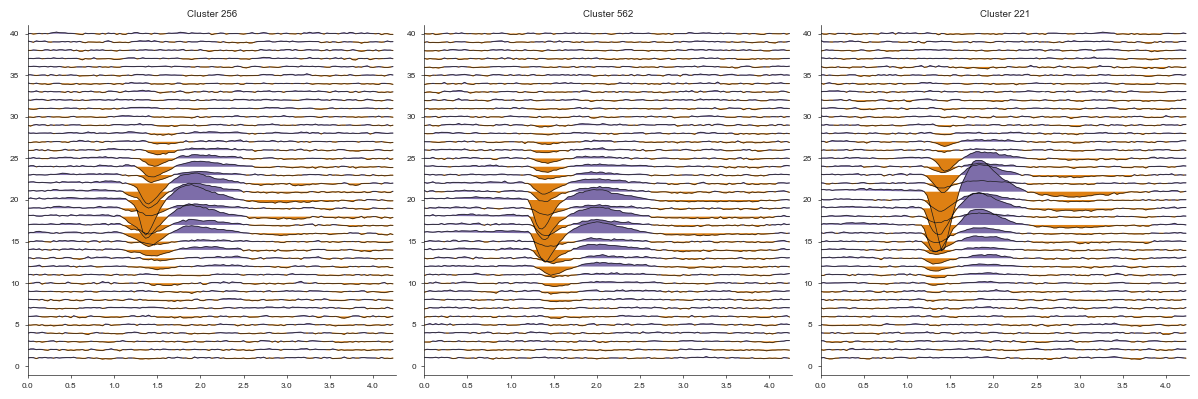

In [2]:
cids = np.random.choice(np.where(clusters['label'] == 1)[0], 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, cid in enumerate(cids):
    wf = waveforms['templates'][cid, :, :]
    ax = ibldsp.waveforms.double_wiggle(wf * 1e6 / 80, fs=30_000, ax=axs[i])
    ax.set(title=f'Cluster {cid}')

## Exploring raw waveforms

For each unit, we have access to up to 256 raw data waveforms chosen randomly from the entire recording. The pre-processing steps included rephasing of the channels, low-cut filtering, bad channel detection and common-average referencing.

In this example below we will load in the raw waveforms for a cluster located in thalamus and compute the resulting waveform after averaging using stacks of 1, 2, 4, 8, 16, 32, 64, 128 individual waveforms. In this way we can track the signal-to-noise ratio (SNR) or our data

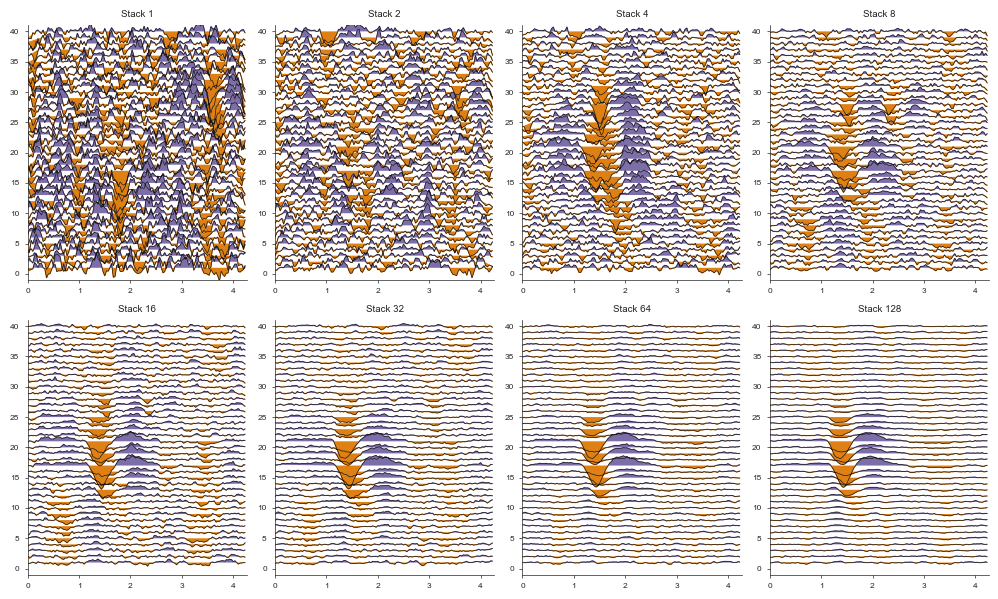

In [3]:
# Instantiante waveform loader
wfl = WaveformsLoader(ss_path)
# Chose a cluster to explore
ic = np.where(np.logical_and(clusters['acronym'] == 'PO', clusters['bitwise_fail'] == 0))[0]
# Load in the raw waveforms
raw_wav, info, channel_map = wfl.load_waveforms(labels=ic[12])

snr = np.zeros(8)
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axs.flat):
    w_stack = np.mean(raw_wav[0, :(2 ** i), :, :], axis=0)
    ax = ibldsp.waveforms.double_wiggle( w_stack  * 1e6 / 80, fs=30_000, ax=axs.flatten()[i])
    ax.set_title(f"Stack {2 ** i}")
    snr[i] = 20 * np.log10(rms(w_stack[19:22, wfl.trough_offset - 10:wfl.trough_offset + 10].flatten()) / np.mean(rms(w_stack)))

For constant gaussian noise in n repeated experiments, we expect the SNR to scale proportionally to the square root of n. In decibels, this corresponds to 3dB / octave. Let’s see how the data compares to the prediction:

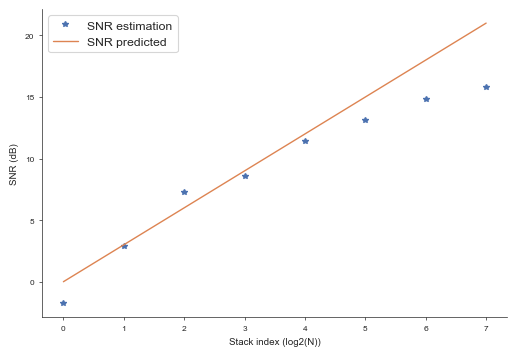

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(8), snr, '*', label='SNR estimation')
ax.plot(np.arange(8), np.arange(8) * 3, label='SNR predicted')
ax.set(xlabel='Stack index (log2(N))', ylabel='SNR (dB)')
ax.legend()